In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches
import time
from matplotlib.collections import PatchCollection
%matplotlib inline

In [2]:
import os

In [6]:
viewingDistance = 100
radius = 10
speed = 4#1
dotNum = 800
timePoints = 1300#1000
pixelsPerDegree = 10 

In [58]:
# function to generate random dot positions at specified distance range from center
def getNewDotPositions(dotNum, minDist=5*pixelsPerDegree, maxDist=90*pixelsPerDegree):
    dists = np.random.uniform(minDist, maxDist, size=dotNum)
    angles = np.pi * np.random.uniform(0, 2, size=dotNum)
    x = dists * np.cos(angles)
    y = dists * np.sin(angles)
    return np.stack([x,y]).T

In [59]:
#pick dots at random screen positions with respect to center point
centerPos=np.array([-60,-20])
pos = getNewDotPositions(dotNum) + centerPos

#find how far they are from center and find unit vectors along which to move them
distToCenter = np.sqrt(np.sum((pos - centerPos)**2, axis=1))
unitVectors = (pos - centerPos)/distToCenter[:, None]

In [60]:
#find the visual angle at which each dot lives
theta = np.deg2rad(distToCenter/pixelsPerDegree)

#find the "time point" when each dot would reach its visual angle if it had started at the original viewing distance
virtualTimePoint = (viewingDistance - (radius/np.tan(theta)))/speed

#probably unnecessary
newTheta = np.copy(theta)
newPos = np.copy(pos)

In [61]:
#Function to repopulate dots that are past 90 degrees visual angle
def repop(repopInds, distToCenter, newPos, unitVectors, newTheta, virtualTimePoint):
    newPos[repopInds] = getNewDotPositions(repopInds.size) + centerPos
    distToCenter[repopInds] = np.sqrt(np.sum((newPos[repopInds] - centerPos)**2, axis=1))
    unitVectors[repopInds] = (newPos[repopInds] - centerPos)/distToCenter[repopInds, None]
    newTheta[repopInds] = np.deg2rad(distToCenter[repopInds]/pixelsPerDegree)
    virtualTimePoint[repopInds] = (viewingDistance - (radius/np.tan(newTheta[repopInds])))/speed
    
    return distToCenter, newPos, unitVectors, newTheta, virtualTimePoint

#Function to redraw dots for the next time point
def redraw(distToCenter, newPos, unitVectors, newTheta, virtualTimePoint):
    #increment "time point" for each dot
    virtualTimePoint += 1
    
    #find new visual angle at that time point
    newTheta = np.arctan(radius/(viewingDistance - speed*(virtualTimePoint+1)))
    
    #repop if necessary
    if any(np.rad2deg(newTheta)<0):
        repopInds = np.where(np.rad2deg(newTheta)<0)[0]
        distToCenter, newPos, unitVectors, newTheta, virtualTimePoint = repop(repopInds, distToCenter, pos, unitVectors, newTheta, virtualTimePoint)
    
    #convert angle to pixels and update dot positions
    newThetaPix = np.rad2deg(newTheta)*pixelsPerDegree
    newPos = unitVectors*newThetaPix[:, None] + centerPos
    
    return distToCenter, newPos, unitVectors, newTheta, virtualTimePoint

In [62]:
pos_array = []
for i in np.arange(timePoints):
    distToCenter, newPos, unitVectors, newTheta, virtualTimePoint = redraw(distToCenter, newPos, unitVectors, newTheta, virtualTimePoint)
    pos_array.append(newPos)
    

In [63]:
pos_array = np.array(pos_array)
pos_array.shape

(1300, 800, 2)

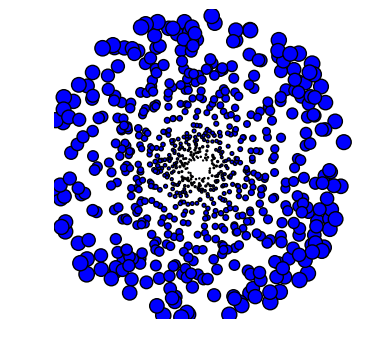

In [64]:
from ipywidgets import widgets, interact, interactive
from IPython.display import display
from IPython.display import Image

scaleFactor = 1/20.
fig, ax = plt.subplots()
ax.set_aspect('equal')
def f(x=0):
    patches = []
    for p in pos_array[x]:
        dist = ((p[0] - centerPos[0])**2 + (p[1]-centerPos[1])**2)**0.5
        radius = dist*scaleFactor
        patches.append(matplotlib.patches.Circle((p[0], p[1]), radius=radius, ec='none', fc=[0, 0, 0]))
    
    collection = PatchCollection(patches)
    ax = plt.gca()
    ax.set_aspect('equal')
    ax.add_collection(collection)
    ax.set_ylim([-900, 900])
    ax.set_xlim([-900, 900])
    ax.axis('off')
    
interact(f, x=(0,timePoints-1,1));

### Parameters to vary:
- density/number of dots
- speed
- size of dots
- coherence?

2 seconds sweep + 1 second intersweep = 3 second stimulus
forward/back = 2 directions
5 speeds
3 sizes
3 densities
15 trials
+15 blank sweeps

In [107]:
((3*3*5*2*3*15)+(15*3))/60.

68.25

In [124]:
from PIL import Image

In [125]:
impath = r'/Users/saskiad/openscope_motion/stimulus/translation'

In [140]:
for i in range(10,20):
    patches = []
    for p in pos_array[i]:
        dist = ((p[0] - centerPos[0])**2 + (p[1]-centerPos[1])**2)**0.5
        radius = dist*scaleFactor
        patches.append(matplotlib.patches.Circle((p[0], p[1]), radius=radius, ec='none', fc=[0, 0, 0]))

    collection = PatchCollection(patches)
    ax = plt.gca()
    ax.set_aspect('equal')
    ax.add_collection(collection)
    ax.set_ylim([-45, 45])
    ax.set_xlim([-70, 70])
    ax.axis('off')
    plt.savefig(os.path.join(impath, str(i)+'.png'))
    plt.close()

In [129]:
im = Image.open(os.path.join(impath, str(i)+'.png'))

In [131]:
np_im = np.array(im)

In [132]:
np_im.shape

(288, 432, 4)

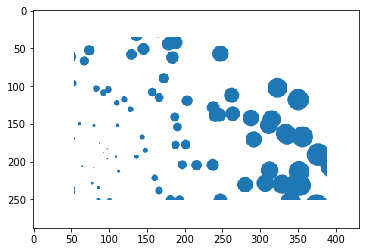

In [138]:
plt.imshow(np_im[:,:,:])

- need to make sure the number of pixels is appropriate
- need to eliminate (or otherwise account for) the border